In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
%load_ext memory_profiler

## Initialize a xarray Dataset

In [2]:
# Set data cube dimension
n_azimuth=2000
n_range=1000
n_time=4

In [3]:
# signal
signal = np.zeros((n_time,n_azimuth,n_range))
signal[0,:,:] = np.tile(np.linspace(0,np.pi,num=n_range), (n_azimuth,1))
for i in range(1,n_time):
    signal[i,:,:] = signal[0,:,:]+i

# noise
np.random.seed(0)
noise = np.random.rand(n_time,n_azimuth,n_range)*2*np.pi

# obs
obs = signal + noise

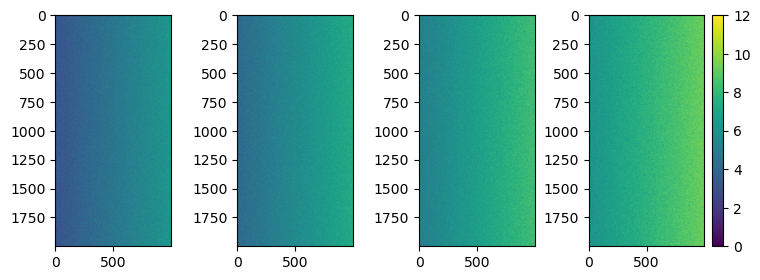

In [4]:
fig, ax = plt.subplots(1,n_time)
fig.set_size_inches(9,3)
for i in range(n_time):
    im = ax[i].imshow(obs[i], vmin=0, vmax=12)
plt.colorbar(im)

In [5]:
ds = xr.Dataset(
    data_vars=dict(
        obs=(["time", "azimuth", "range"], obs),
    ),
    coords=dict(
        azimuth=np.arange(n_azimuth),
        range=np.arange(n_range),
        time=np.arange(n_time),
    ),
)
ds

<xarray.Dataset>
Dimensions:  (time: 4, azimuth: 2000, range: 1000)
Coordinates:
  * azimuth  (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range    (range) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * time     (time) int64 0 1 2 3
Data variables:
    obs      (time, azimuth, range) float64 3.448 4.497 3.794 ... 8.004 7.702

In [6]:
# Export to Zarr
ds.to_zarr("database.zarr", mode='w')

In [7]:
#Check size
! du -h --max-depth=0 database.zarr

55M	database.zarr


## Operation : subsetting

<xarray.DataArray 'obs' ()>
array(34885)


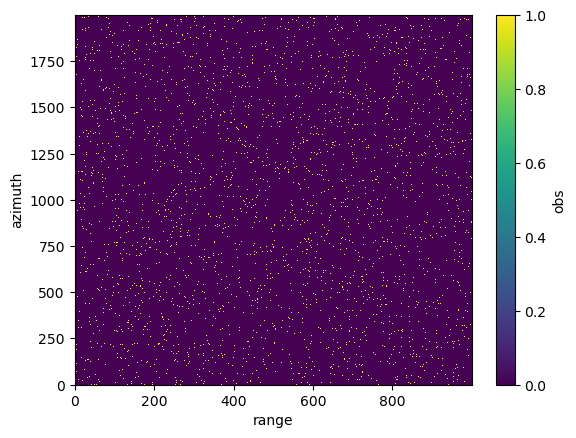

In [8]:
# Select the low std pixels
mask = ds.obs.std(axis=0)<0.5
print(mask.sum())
mask.plot()

In [9]:
ds_masked = ds.where(mask)
ds_masked

<xarray.Dataset>
Dimensions:  (time: 4, azimuth: 2000, range: 1000)
Coordinates:
  * azimuth  (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range    (range) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * time     (time) int64 0 1 2 3
Data variables:
    obs      (time, azimuth, range) float64 nan nan nan nan ... nan nan nan nan

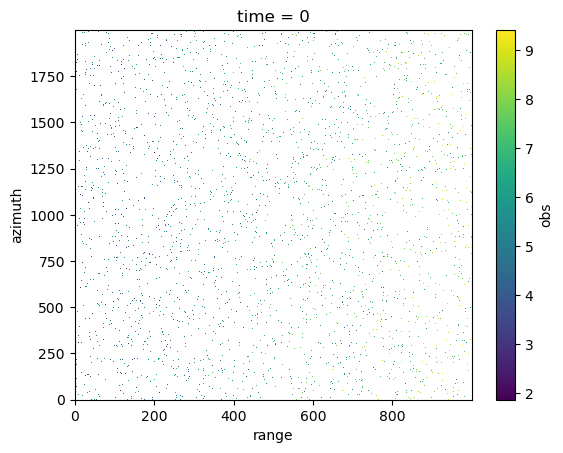

In [10]:
# Plot first epoch
ds0 = ds_masked.isel(time=0)
ds0.obs.plot()

#### Subset to a pointset

In [11]:
pointset = ds_masked.stack(points=('azimuth', 'range'))
pointset

<xarray.Dataset>
Dimensions:  (time: 4, points: 2000000)
Coordinates:
  * time     (time) int64 0 1 2 3
  * points   (points) object MultiIndex
  * azimuth  (points) int64 0 0 0 0 0 0 0 ... 1999 1999 1999 1999 1999 1999 1999
  * range    (points) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    obs      (time, points) float64 nan nan nan nan nan ... nan nan nan nan nan

In [12]:
pointset = pointset.dropna('points', subset=['obs'])
pointset

<xarray.Dataset>
Dimensions:  (time: 4, points: 34885)
Coordinates:
  * time     (time) int64 0 1 2 3
  * points   (points) object MultiIndex
  * azimuth  (points) int64 0 0 0 0 0 0 0 ... 1999 1999 1999 1999 1999 1999 1999
  * range    (points) int64 20 71 163 165 244 281 ... 743 768 769 850 905 948
Data variables:
    obs      (time, points) float64 6.212 3.168 5.956 ... 6.254 8.466 6.026

#### Update the original database

In [13]:
%memit
pointset['obs1'] = pointset.obs+100
pointset

peak memory: 840.34 MiB, increment: 0.00 MiB


<xarray.Dataset>
Dimensions:  (time: 4, points: 34885)
Coordinates:
  * time     (time) int64 0 1 2 3
  * points   (points) object MultiIndex
  * azimuth  (points) int64 0 0 0 0 0 0 0 ... 1999 1999 1999 1999 1999 1999 1999
  * range    (points) int64 20 71 163 165 244 281 ... 743 768 769 850 905 948
Data variables:
    obs      (time, points) float64 6.212 3.168 5.956 ... 6.254 8.466 6.026
    obs1     (time, points) float64 106.2 103.2 106.0 ... 106.3 108.5 106.0

In [14]:
%memit
ds = xr.open_zarr('database.zarr')
ds

peak memory: 844.71 MiB, increment: 0.00 MiB


<xarray.Dataset>
Dimensions:  (azimuth: 2000, time: 4, range: 1000)
Coordinates:
  * azimuth  (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range    (range) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * time     (time) int64 0 1 2 3
Data variables:
    obs      (time, azimuth, range) float64 dask.array<chunksize=(1, 500, 250), meta=np.ndarray>

In [15]:
ds.nbytes

64024032

In [16]:
ds_pointset = ds.stack(points=('azimuth', 'range'))
ds_pointset

<xarray.Dataset>
Dimensions:  (time: 4, points: 2000000)
Coordinates:
  * time     (time) int64 0 1 2 3
  * points   (points) object MultiIndex
  * azimuth  (points) int64 0 0 0 0 0 0 0 ... 1999 1999 1999 1999 1999 1999 1999
  * range    (points) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    obs      (time, points) float64 dask.array<chunksize=(1, 125000), meta=np.ndarray>

In [55]:
from scipy import sparse as scisp
dense = da_dense.data
spm = sparse.COO.from_numpy(da_dense.data)
spm

Format,coo
Data Type,float64
Shape,"(4, 2000000)"
nnz,139540
Density,0.0174425
Read-only,True
Size,3.2M
Storage ratio,0.1


In [68]:
%memit
import sparse

da_dense = xr.DataArray(coords=ds_pointset.coords)
da_dense.loc[dict(points = pointset.obs1.points)] = pointset.obs1.data


dense = da_dense.data
dense[np.where(np.isnan(dense))] = 0
spm = sparse.COO.from_numpy(da_dense.data, fill_value=dense[0,0])

da_sparse= xr.DataArray(data=sparse.COO(da_dense.data), coords=ds_pointset.coords) 

da_sparse

peak memory: 3408.45 MiB, increment: 0.00 MiB


Format,coo
Data Type,float64
Shape,"(4, 2000000)"
nnz,139540
Density,0.0174425
Read-only,True
Size,3.2M
Storage ratio,0.1


In [69]:
del da_dense

In [70]:
da_sparse.nbytes

64000000

In [73]:
%memit
ds = ds.assign(obs1=da_sparse)
ds

peak memory: 3346.19 MiB, increment: 0.00 MiB


<xarray.Dataset>
Dimensions:  (azimuth: 2000, time: 4, range: 1000, points: 2000000)
Coordinates:
  * azimuth  (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range    (range) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * time     (time) int64 0 1 2 3
Dimensions without coordinates: points
Data variables:
    obs      (time, azimuth, range) float64 dask.array<chunksize=(1, 500, 250), meta=np.ndarray>
    obs1     (time, points) float64 <COO: nnz=139540, fill_value=0.0>

In [77]:
# ds0 = ds.isel(time=0)
# ds0.obs1.plot()

array([0., 0., 0., ..., 0., 0., 0.])

In [78]:
%memit
# Update zarr
ds.to_zarr("database.zarr", mode='a')

peak memory: 3627.35 MiB, increment: -1.33 MiB


TypeError: SparseArray.astype() got an unexpected keyword argument 'order'

In [20]:
#Check size
! du -h --max-depth=0 database.zarr

60M	database.zarr


### ToDos
- Chunck Writing for memory optimization, [exmaple](https://stackoverflow.com/questions/70452305/xarray-larger-than-memory-array-using-map-blocks-dumping-results-into-zarr-sto)

- Access management for variables. 